# Data Visualization

## Stats 141B

## Lecture 12

## Prof. Sharpnack

## Lecture slides at http://anson.ucdavis.edu/~jsharpna/141Blectures/

## Lecture repository at https://github.com/jsharpna/141Blectures/

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [3]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10,6)

In [4]:
## set thousands arg

OH = pd.read_csv('../data/OHvotes.csv',thousands=',')

OH = OH.set_index(['County Name','Precinct Name']) # set indices

cols = OH.columns.str.replace(' ','_')
cols = cols.str.replace('.','')
cols = cols.str.replace('*','')
cols = cols.str.replace('_\(.+\)','')
cols = cols.str.lower()

OH.columns = cols

## Let's remove some candidates

candidates = OH.columns.values[9:] # isolate candidate names 

## add no vote for pres
OH['no_pres'] = OH['total_voters'] - OH[candidates].sum(axis=1)
candidates = candidates.tolist() + ['no_pres']

## Quick look at percentages
totals = OH[candidates].sum()
total_percs = totals / totals.sum()

## Isolate the candidates with more than .1% of vote
ser_cands = total_percs[total_percs > 0.001].index.values.tolist()
keep_cols = ['total_voters','registered_voters'] + ser_cands
OH = OH[keep_cols]
OHsum = OH.sum()

## extract percentages
OH_percs = OH[keep_cols].transform(lambda x: x / OH['total_voters'])
OH = OH.join(OH_percs,rsuffix="_perc")

## Aggregate by counties and recompute swing vars
OH_counties = OH[keep_cols].groupby(level=0).sum()
OH_counties['swing'] = OH_counties.eval('(donald_j_trump - hillary_clinton) / total_voters')
OH_counties['swing_cat'] = pd.cut(OH_counties['swing'],[-1,-.1,.1,1],labels=['blue','purple','red'])

## Extract area dataset
OHarea = pd.read_excel('../data/OHarea.xlsx')
OHarea = OHarea.set_index('County')
OHarea.columns = ['area']

## Join datasets and compute density
OH_counties = OH_counties.join(OHarea)
OH_counties['voter_density'] = OH_counties.eval('registered_voters / area')

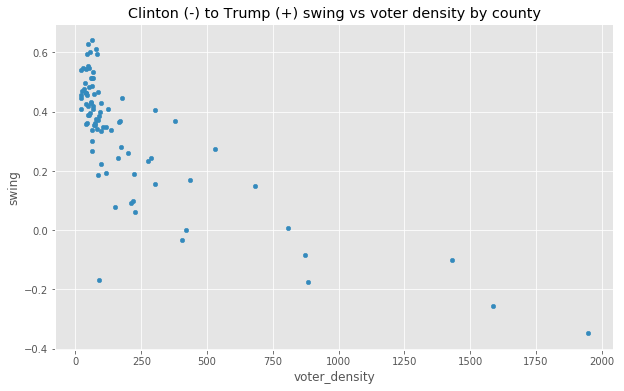

In [5]:
## Voter density plot

OH_counties.plot('voter_density','swing',kind='scatter',
                 title='Clinton (-) to Trump (+) swing vs voter density by county')

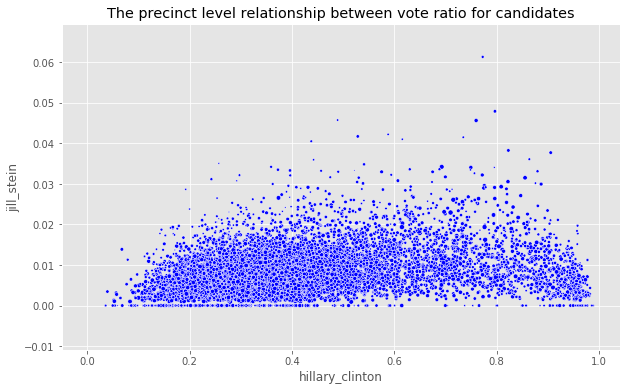

In [6]:
## Precinct percentages for Stein v Clinton

cand1, cand2 = 'hillary_clinton','jill_stein'
candperc1, candperc2 = cand1 + "_perc", cand2 + "_perc"
OH.plot(candperc1,candperc2,color='b',s = OH['total_voters']/50,
        edgecolors='white',kind='scatter')
plt.xlabel(cand1)
plt.ylabel(cand2)
plt.title("The precinct level relationship between vote ratio for candidates")
plt.show()

### Causal effects of voting systems on Clinton-Trump swing?

There was serious public concern about the hacking of certain voting system.  Particularly, voting systems such as the Accuvote TS are touch screens that runs off of Windows CE and maintain the votes in memory.  These have been noted to be vunerable, as could any voting systems where a computer is involved (including optical scanners).  I am interested to see if there is evidence in the voting record of widespread hacking.

In [40]:
## Extract and merge voting system data

OH_machine = pd.read_excel('../data/OHmachines.xlsx',type='category',header=None)
OH_machine = OH_machine.rename(columns = {0:"County Name", 1:"system"})
OH_machine = OH_machine.set_index("County Name")

In [41]:
OH_machine.head()

,system
County Name,
Williams,Hart eScan
Defiance,Premier AccuVote-TSX
Paulding,Premier AccuVote-TSX
Van Wert,Premier AccuVote
Mercer,Premier AccuVote-TSX


In [42]:
OH_machine['system'].unique() # unique values for series

array(['Hart eScan', 'Premier AccuVote-TSX ', 'Premier AccuVote',
       ' ES&S Model 100 ', '** Multiple ES&S Optical Scanners **',
       'ES&S DS200', 'ES&S iVotronic ', ' Dominion', ' ES&S DS200',
       ' Unisyn OpenElect'], dtype=object)

In [43]:
## clean and join
OH_machine['system'] = OH_machine['system'].str.strip() # noticed this issue by looking at data
OH_counties = OH_counties.join(OH_machine)

In [44]:
## Group by system and sum, recompute swing, voter density
sys_cty_comp = OH_counties.groupby('system').sum()
sys_cty_comp['swing'] = sys_cty_comp.eval('(donald_j_trump - hillary_clinton) / total_voters')
sys_cty_comp['voter_density'] = sys_cty_comp.eval('registered_voters / area')

In [45]:
sys_cty_comp[['swing','voter_density']]

,swing,voter_density
system,,
** Multiple ES&S Optical Scanners **,0.611100,78.890854
Dominion,0.391921,60.026588
ES&S DS200,-0.147699,385.701593
ES&S Model 100,0.216150,127.417605
ES&S iVotronic,-0.090957,390.430986
Hart eScan,-0.079225,731.759143
Premier AccuVote,0.421064,64.798846
Premier AccuVote-TSX,0.197850,160.888202
Unisyn OpenElect,0.594817,42.453790


### Does this mean that the election was hacked?

- Percent swing is highly dependent on election system!
- but, but, but so is voter density

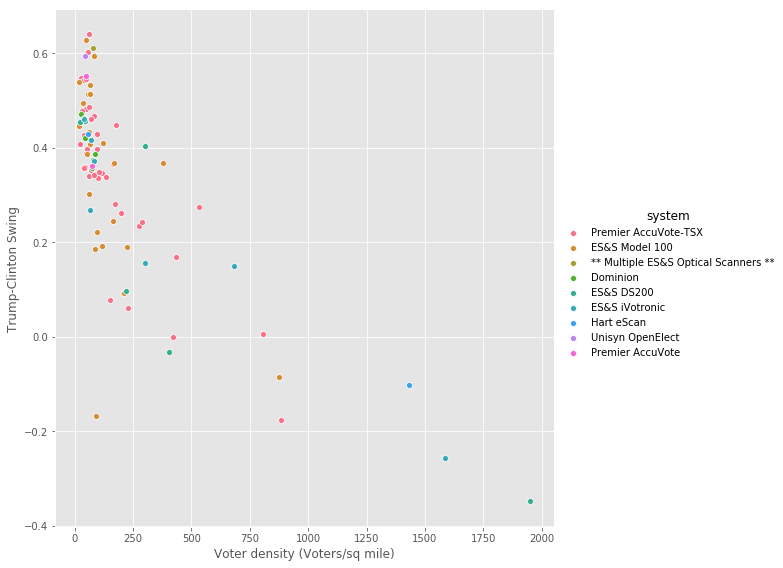

In [46]:
## use Seaborn to plot these three vars

sns.pairplot(x_vars=['voter_density'], y_vars=['swing'], \
             data=OH_counties, hue='system', height=8)
plt.xlabel('Voter density (Voters/sq mile)')
plt.ylabel('Trump-Clinton Swing')
plt.show()

### Final conclusions for OH 2016 voting analysis

1. Election outcome in a county is highly dependent on the voter density (voters/sqr. mile) with more rural areas reliably voting Republican (except Athens county)
2. Third party candidate votes are weakly associated with the election outcome, with red precincts tending to vote more for Johnson, and blue precincts tending toward Stein.
3. There is insufficient statistical evidence for a causal effect of voting system on the election outcome.

## Data Visualization

### Old way

- Named plots:
 - histogram, scatterplot, time series plot, etc.

- Increasingly complicated named plots (e.g. Hexbin plot with marginal distributions)

- Lacks versitility: many options as you build a plot, a named plot can only give you so many options
 
### New way

- Deconstructing the plot: understand and name the components
- Grammar of graphics: rules that guide how these fit together

## Data Visualization: Python landscape

### Low level drawing
- Matplotlib

### Named plots
- Pyplot
- Seaborn
- Pandas dataframe.plot

### Grammar of graphics
- Plotnine
- Ggplot (seems depreciated)

### Interactive
- Mpld3
- Plotly
- Bokeh

### Why visualize data at all?

Arguments for:
- Let's people see the data
- The eye can extract it's own statistics and conclusions
- Explore the data, guide statistical analysis
- More impactful/engaging statistical content

Arguments against:
- Can mislead people without being an outright lie
- Often is a graphical design exercise / data is not the focus anymore
- Humans find patterns where there are none

![](./reese.png)

![](./bikewreck.png)

* https://www.sacbee.com/news/local/transportation/article151302502.html

### How to correct this issue?

- add textual context, should alert the reader to the issue of un-observed baseline.
- more educated data visualization viewers
- do not overexaggerate conclusions: "where Sacramento bicyclists are hit most often"
- choose a different visualization / scrap the analysis all together

### Conclusions

- context matters: textual and viewer experience
- visualization does not overcome statistical issues: multiple testing problems, spurious patterns, etc.

### Visualization is only as good as statistics

- hidden multiple tests
- implied / unreported baselines
- possible confounding variables

![](./divorce.png)

* http://tylervigen.com/spurious-correlations

## Graphical excellence

- shows the data
- induce the viewer to think about substance rather than methodology
- avoid distortion of data
- present many numbers in small space
- make large datasets coherent
- encourage the eye to compare different pieces of data
- reveal the data at several levels of detail
- serve a reasonably clear purpose: description, exploration, tabulation, or decoration
- be closely integrated with the statistical and verbal descriptions of a data set

(The Visual Display of Quantitative Info., Tufte)


### http://rhythm-of-food.net/

- Read the instructions (how to read this visualization)
- To play this game:
 - Look at the visualization
 - Extract conclusions quickly

![](quinoa.png)

![](pumpkin.png)

![](redcurrant.png)

### Pros v. Cons?

![](http://www.datavis.ca/gallery/minard/1812-2.jpg)

- Caption translated to English: "The numbers of men present are represented by the widths of the colored zones at a rate of one millimeter for every ten thousand men; they are further written across the zones. The [tan] designates the men who enter Russia, the black those who leave it."
- Original image of Minard's graphic from John Schneider's Napoleonic Literature page, linked on http://www.datavis.ca/gallery/re-minard.php

![](http://www.datavis.ca/gallery/minard/zelazny-minard.png)

- Powerpoint reproduction from http://extremepresentation.typepad.com/blog/2010/06/